In [20]:
import pandas  as pd
import numpy   as np
import seaborn as sns   
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
    accuracy_score, classification_report,
    confusion_matrix)
from sklearn.tree import DecisionTreeClassifier
import time
import matplotlib.pyplot as plt 
from imblearn.under_sampling import RandomUnderSampler 
import xgboost as xgb
from hyperopt import fmin, tpe, hp,Trials, STATUS_OK
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler

In [21]:
df = pd.read_csv('datasets/credit_clients.csv')
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_SEP,PAY_AUG,PAY_JUL,PAY_JUN,PAY_MAY,PAY_APR,PAY_AMT_SEP,PAY_AMT_AUG,PAY_AMT_JUL,PAY_AMT_JUN,PAY_AMT_MAY,PAY_AMT_APR,default payment next month,BILL_AMT
0,20000,2,2,1,24,2,2,-1,-1,-2,-2,0,689,0,0,0,0,1,1284.000000
1,120000,2,2,2,26,-1,2,0,0,0,2,0,1000,1000,1000,0,2000,1,2846.166667
2,90000,2,2,2,34,0,0,0,0,0,0,1518,1500,1000,1000,1000,5000,0,16942.166667
3,50000,2,2,1,37,0,0,0,0,0,0,2000,2019,1200,1100,1069,1000,0,38555.666667
4,50000,1,2,1,57,-1,0,-1,0,0,0,2000,36681,10000,9000,689,679,0,18223.166667


In [22]:
df.shape

(30000, 19)

In [23]:
df['default payment next month'].value_counts() 

default payment next month
0    23364
1     6636
Name: count, dtype: int64

In [24]:
x = df.drop('default payment next month', axis=1)
y = df['default payment next month']

In [25]:
# let's scale the data
scale = MinMaxScaler()
x = scale.fit_transform(x)

In [26]:
rus = RandomUnderSampler(random_state=42)
x, y = rus.fit_resample(x, y)

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [28]:
# I train the Decision Tree model with same data for Linear Regression
clf = DecisionTreeClassifier(random_state=42)
clf.fit(x_train, y_train)
forecast = clf.predict(x_test)
accuracy = accuracy_score(y_test, forecast)

In [29]:
print(classification_report(y_test, forecast))
print(f'Accuracy: {accuracy*100:.2f}')

              precision    recall  f1-score   support

           0       0.62      0.62      0.62      2010
           1       0.61      0.62      0.62      1972

    accuracy                           0.62      3982
   macro avg       0.62      0.62      0.62      3982
weighted avg       0.62      0.62      0.62      3982

Accuracy: 61.83


Decision Tree got worse accuracy than Logistic Regression, but model works fairly for both values.

In [30]:
# Defining the hyperparameter space
space = {
    
    'max_depth': hp.quniform('max_depth', 2, 8, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, -2),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    
    
}

def objective(params):
    
    global prediction
    
    params['max_depth'] = int(params['max_depth'])  
    params['n_estimators'] = int(params['n_estimators'])
    
    model = xgb.XGBClassifier(**params,
    tree_method='hist',
    objective='binary:logistic',
    random_state=42)
    
    
    model.fit(x_train, y_train)
    prediction = model.predict(x_test)
    score = accuracy_score(y_test, prediction)
    return {'loss': -score, 'status': STATUS_OK}


best_params = fmin(objective, space, algo=tpe.suggest, max_evals=100)
print("Best set of hyperparameters: ", best_params)

100%|██████████| 100/100 [00:55<00:00,  1.79trial/s, best loss: -0.7172275238573581]
Best set of hyperparameters:  {'colsample_bytree': 0.6575484817908377, 'learning_rate': 0.008307339108102404, 'max_depth': 4.0, 'n_estimators': 772.0, 'subsample': 0.6019953199512135}


In [31]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.68      0.81      0.74      2010
           1       0.76      0.60      0.67      1972

    accuracy                           0.71      3982
   macro avg       0.72      0.71      0.71      3982
weighted avg       0.72      0.71      0.71      3982



In [32]:
accuracy = accuracy_score(y_test, prediction)
print(f'Accuracy: {accuracy*100:.2f}') 

Accuracy: 70.99


In [ ]:
# I used Hyperopt to find the best hyperparameters for the XGBoost model. But improving is not quite significant.

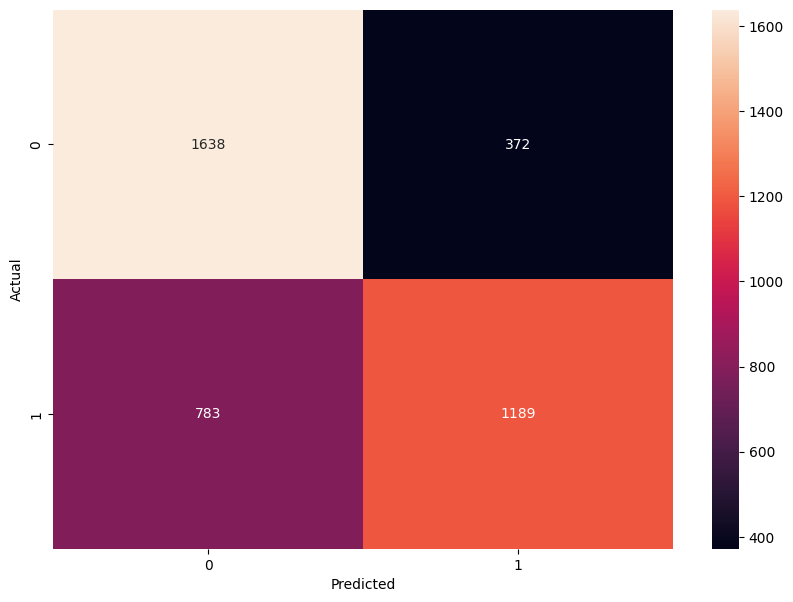

In [33]:
# confusion matrix
cm = confusion_matrix(y_test, prediction)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## <span style="color: #20C997;">Personal Analysis</span>

XGBoost model works better than others, but it has better performing for 0 or no.